In [18]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Calibration C
Performed inside while cooking 2022-01-18 with Sensirion sensors {1, 2, 3, 4, 5, 6}.

In [19]:
# Set param [e.g. PM2.5 or NC2.5]
param = 'PM2.5'
unit = 'µg/m³'
date = '2021-12-14'

# Get calibration dataframe
c_df = get_calibrate_df(date, '../data/calibration_C')

# figure folder
fig_folder = '../results/calibration_C'

## 1 Overall initial statistics

General statistics for the whole dataset.

**Plot sensors over time**

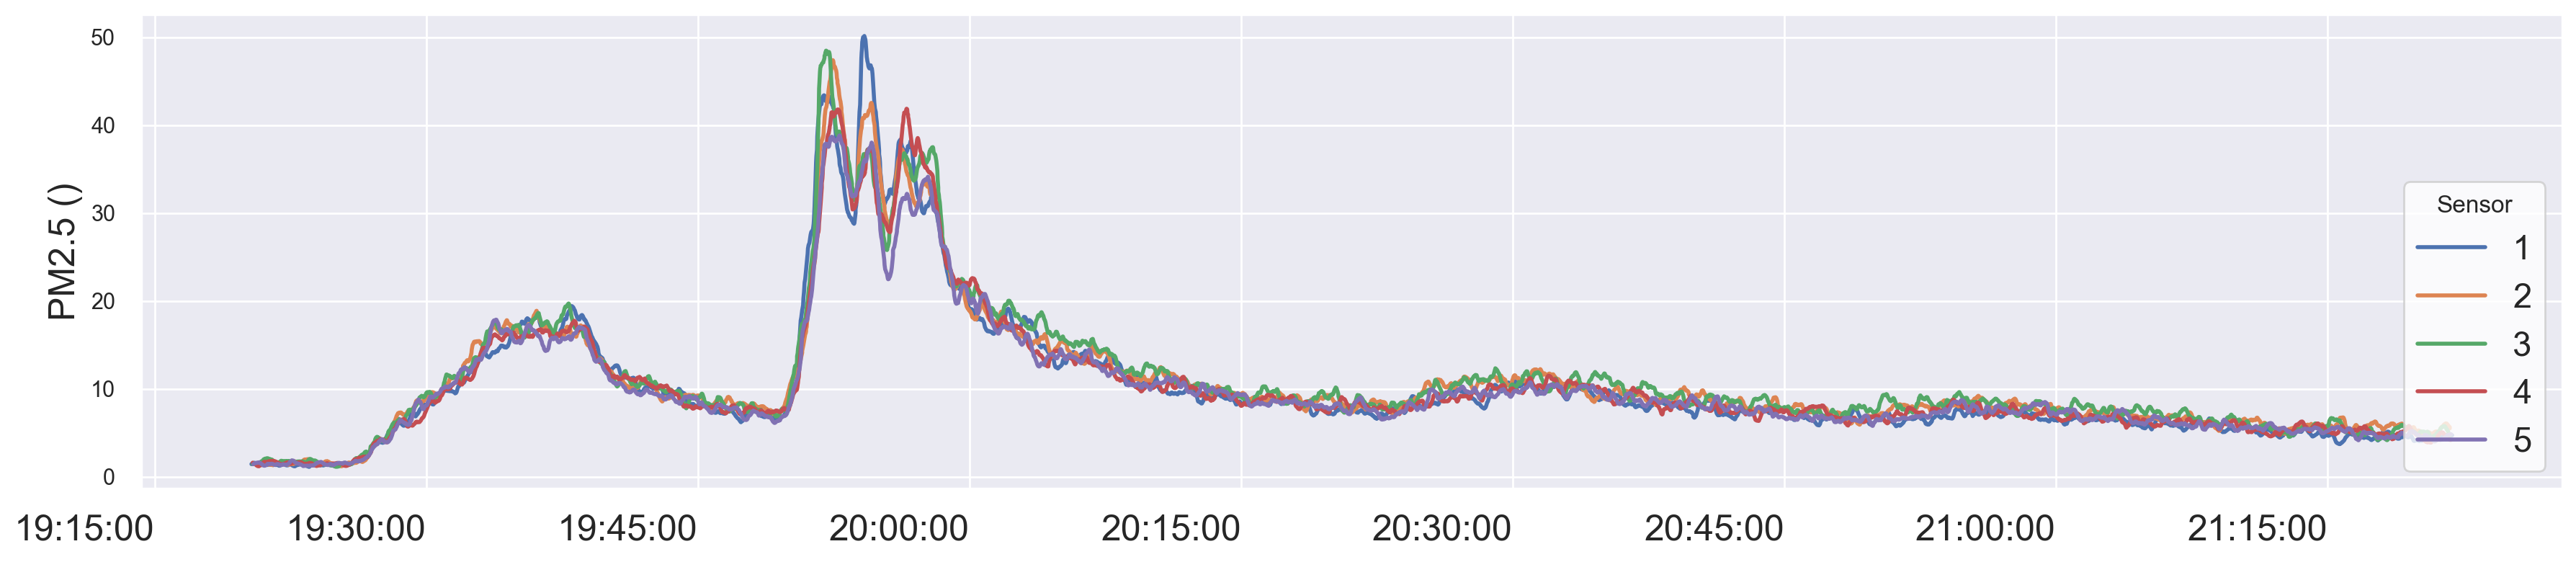

In [20]:
plot_sensors_over_time(
    c_df, 
    title='Calibration C Sensirion', 
    param=param, 
    size=[18,4],
    fig_name=f'{fig_folder}/sensirion_over_time({param}).pdf'
)

In [21]:
grand_mean = c_df[param].mean()
grand_median = c_df[param].median()
grand_mode = c_df[param].mode()
grand_std = c_df[param].std()
confidence_interval = CI95(c_df[param].values)

print(f'Mean±Std: {param} = {round(grand_mean, 2)}±{round(grand_std, 2)} {unit}')
print(f'Mean±CI 95%: {param} = {round(grand_mean, 2)}±{round(confidence_interval, 3)} {unit}')
c_df[param].describe()

Mean±Std: PM2.5 = 10.46±7.4 µg/m³
Mean±CI 95%: PM2.5 = 10.46±0.079 µg/m³


count    33971.000000
mean        10.455273
std          7.399706
min          1.110000
25%          6.700000
50%          8.380000
75%         11.050000
max         50.140000
Name: PM2.5, dtype: float64

#### Standard deviations, etc.

The "grand std" shows how much every sample varies from the total mean. The coefficient of variation is computed as follows:

$$CV = \frac{\sigma}{grand\ mean}$$

In [22]:
CV = grand_std / grand_mean
CV

0.7077487565543351

*How much do the medians vary from the total median?* (same formula as standard deviation but with medians)

In [23]:
median_diff = 0

for sensor, grp in c_df.groupby('Sensor'):
    median_diff += (grp[param].median() - grand_median) ** 2
    
median_diff = np.sqrt(median_diff / (len(c_df['Sensor'].unique()) - 1))

median_diff

0.4486437896594581

## 2 Central tendency and variability

The confidence interval is computed as follows:

$$CI95 = z\frac{\sigma}{\sqrt{n}}$$

where $z=1.96$ is the z-score for a 95% confidence interval, $\sigma$ the standard deviation, and $n$ the sample size.

In [24]:
mean_df = c_df.groupby('Timestamp').mean()
mean_df['Timestamp'] = mean_df.index
mean_df['Sensor'] = 'Mean'
mean_df['UID'] = 'Mean'

mean_df.reset_index(drop=True, inplace=True)

total_df = pd.concat([c_df, mean_df])

central = total_df.groupby('Sensor').agg(
    {param: 
     ['mean', 'median', mode, 'min', 'max', x_range, sample_std, standard_error, CI95]
    }
)

central.head(7)

PM2.5                                                      \
             mean    median   mode     min    max  x_range sample_std   
Sensor                                                                  
1       10.212179  7.860000  7.400  1.1100  50.14  49.0300   7.825916   
2       10.780171  8.740000  8.130  1.1800  47.39  46.2100   7.403829   
3       11.003634  8.900000  8.040  1.1200  48.47  47.3500   7.551687   
4       10.249119  8.045000  7.940  1.1800  41.86  40.6800   7.312262   
5       10.031627  8.230000  1.440  1.2000  38.82  37.6200   6.822108   
Mean    10.447755  8.366667  7.692  1.2875  45.46  44.1725   7.340036   

                                 
       standard_error      CI95  
Sensor                           
1            0.094827  0.185860  
2            0.089884  0.176172  
3            0.091598  0.179532  
4            0.088753  0.173955  
5            0.082791  0.162271  
Mean         0.085950  0.168462

**Comment**

Sensor 3 has the largest range and highest standard deviation. Sensor 1 has the lowest range. Sensor 4 has the lowest standard deviation.

## 3 Distribution
How is the data distributed?

### 3.1 Box plots

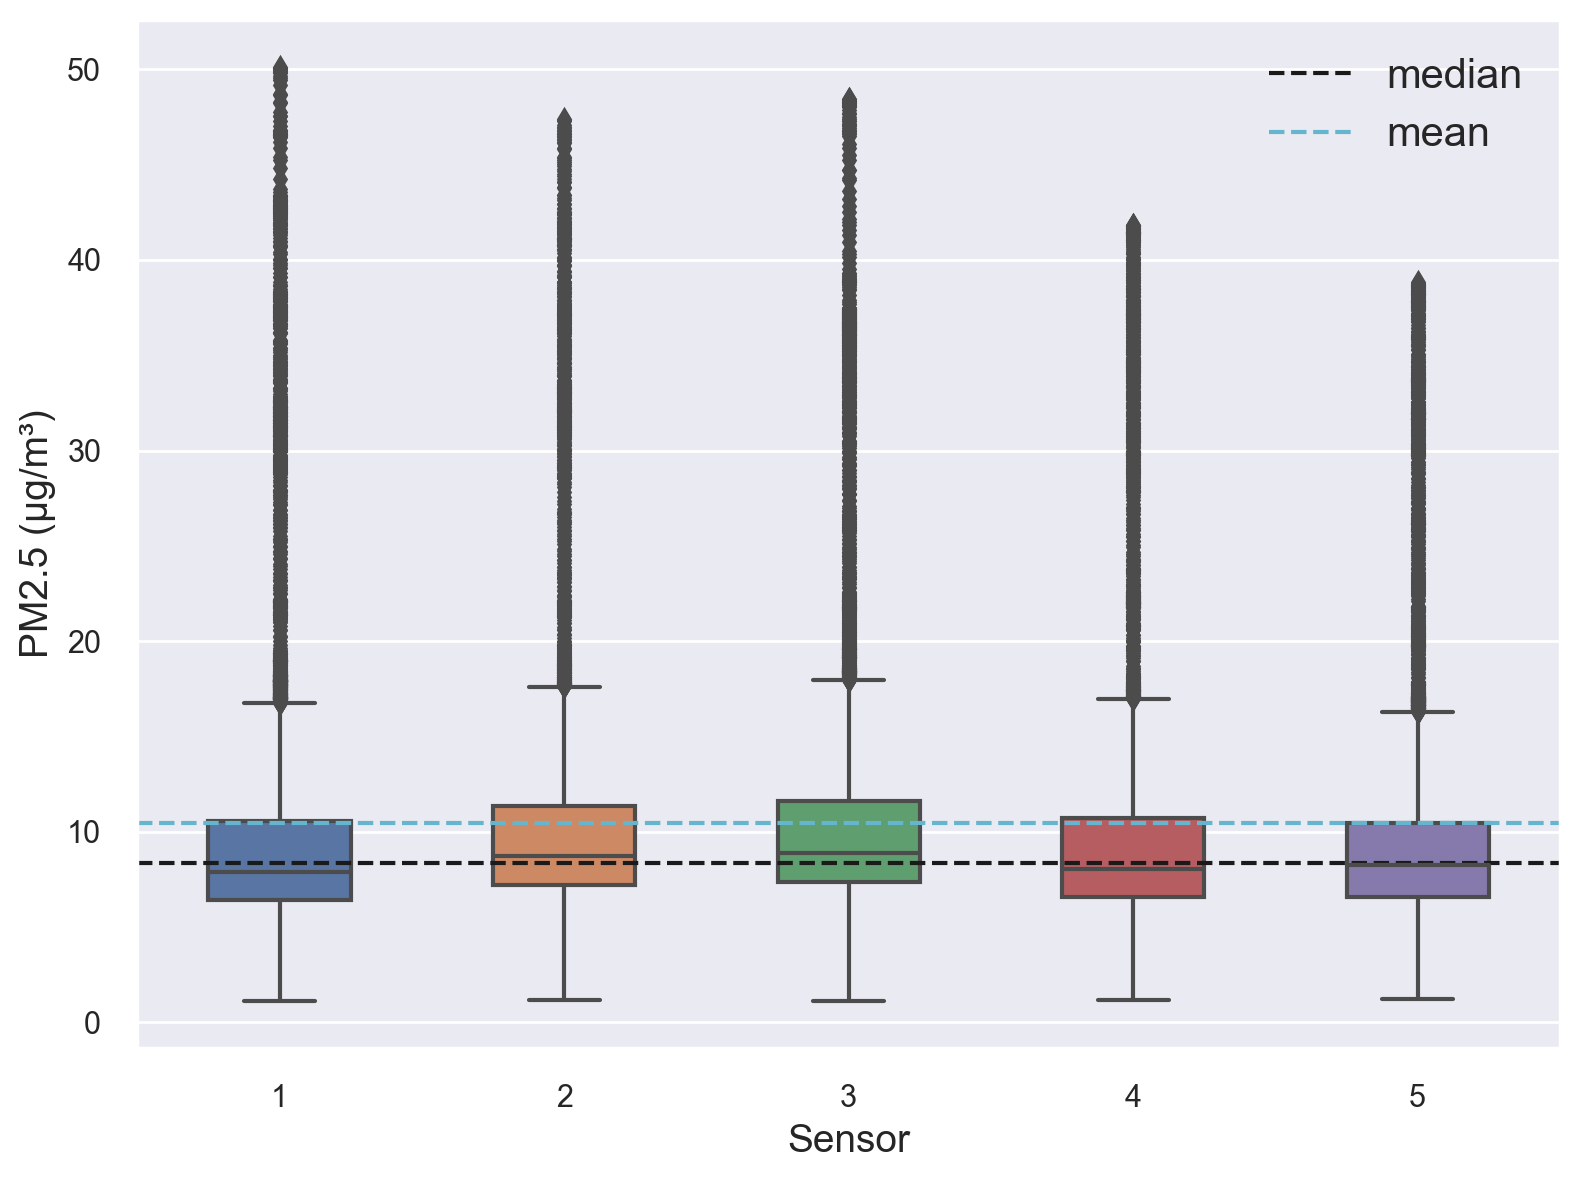

In [25]:
fig, ax = plt.subplots(figsize=[8,6], dpi=200)

sns.boxplot(x='Sensor', y=param, data=c_df, width=0.5)

plt.axhline(c_df[param].median(), c='k', linestyle='--', label='median')
plt.axhline(c_df[param].mean(), c='c', linestyle='--', label='mean')

plt.ylabel(f'{param} ({unit})', fontsize=14)
plt.xlabel('Sensor', fontsize=14)
plt.legend(fontsize=15)
plt.tight_layout()
#plt.title('Box Plots Calibration A')
plt.savefig(f'{fig_folder}/box_plots({param}).pdf', dpi=300, bbox_inches="tight")
plt.show()

**Comment**

### 3.2 Outliers

In [26]:
# Compute median, lower quartile, upper quartile, IQR, lower limit and upper limit
quantiles = c_df.groupby('Sensor').agg(
    {param: 
     [Q1, Q2, Q3, IQR, lowerLimit, upperLimit, outliers, prcnt_outliers, 'count']
    }
)

# Display stats
quantiles

PM2.5                                                     \
          Q1     Q2     Q3   IQR lowerLimit upperLimit outliers   
Sensor                                                            
1       6.43  7.860  10.56  4.13      0.235     16.755    883.0   
2       7.21  8.740  11.37  4.16      0.970     17.610    629.0   
3       7.37  8.900  11.61  4.24      1.010     17.970    732.0   
4       6.57  8.045  10.73  4.16      0.330     16.970    668.0   
5       6.55  8.230  10.45  3.90      0.700     16.300    785.0   

                             
       prcnt_outliers count  
Sensor                       
1           12.964322  6811  
2            9.270450  6785  
3           10.769457  6797  
4            9.840896  6788  
5           11.561119  6790

In [27]:
# Get exact values of outliers
outliers_dict = {}

for sensor, grp in c_df.groupby('Sensor'):    
    lower = quantiles[param]['lowerLimit'][sensor]
    upper = quantiles[param]['upperLimit'][sensor]
    outliers_dict[sensor] = grp.loc[(grp[param] < lower) | (grp[param] > upper)][param].values

outliers_dict

{'1': array([16.76, 16.8 , 16.85, 16.95, 16.94, 16.98, 16.96, 16.99, 17.01,
        17.07, 17.11, 17.17, 17.22, 17.23, 17.27, 17.32, 17.39, 17.47,
        17.53, 17.64, 17.64, 17.62, 17.57, 17.52, 17.44, 17.44, 17.43,
        17.41, 17.4 , 17.41, 17.43, 17.5 , 17.6 , 17.85, 17.94, 17.96,
        18.02, 18.01, 17.96, 17.94, 17.89, 17.87, 17.86, 17.8 , 17.77,
        17.74, 17.7 , 17.72, 17.72, 17.71, 17.73, 17.75, 17.73, 17.75,
        17.79, 17.86, 18.  , 18.08, 18.15, 18.21, 18.19, 18.21, 18.21,
        18.22, 18.23, 18.22, 18.2 , 18.17, 18.14, 18.07, 18.05, 18.03,
        17.96, 17.85, 17.58, 17.47, 17.35, 17.24, 17.15, 17.08, 17.08,
        16.99, 16.99, 16.98, 16.97, 17.  , 17.04, 17.08, 17.15, 17.2 ,
        17.24, 17.22, 17.19, 17.13, 17.11, 17.06, 17.02, 17.05, 17.07,
        17.08, 17.1 , 17.06, 17.  , 17.03, 17.06, 17.03, 16.97, 16.87,
        16.81, 16.85, 17.06, 17.14, 17.27, 17.42, 17.6 , 17.76, 17.85,
        17.9 , 17.9 , 17.94, 17.94, 17.91, 17.94, 18.03, 18.27, 18.38,
 

**Comment**

Sensor 3 has the most outliers, followed by Sensor 2, Sensor 5, Sensor 4, and lastly Sensor 1. Not that many outliers in comparison to the total amount of samples taken. However, 0.07-0.36% of sample points are still contributing to a slightly different mean.

### To Latex

In [28]:
latex = pd.merge(central, quantiles, on='Sensor')
latex = latex['PM2.5'][['mean', 'median', 'sample_std', 'outliers', 'count']]

for index, row in latex.iterrows():
    print(f'{index} & {round(row[0], 2)} & {round(row[1], 2)} & {round(row[2], 2)} & {int(float(row[3]))} & {int(float(row[4]))} \\\\')
    
    

1 & 10.21 & 7.86 & 7.83 & 883 & 6811 \\
2 & 10.78 & 8.74 & 7.4 & 629 & 6785 \\
3 & 11.0 & 8.9 & 7.55 & 732 & 6797 \\
4 & 10.25 & 8.04 & 7.31 & 668 & 6788 \\
5 & 10.03 & 8.23 & 6.82 & 785 & 6790 \\


### 3.3 Histograms

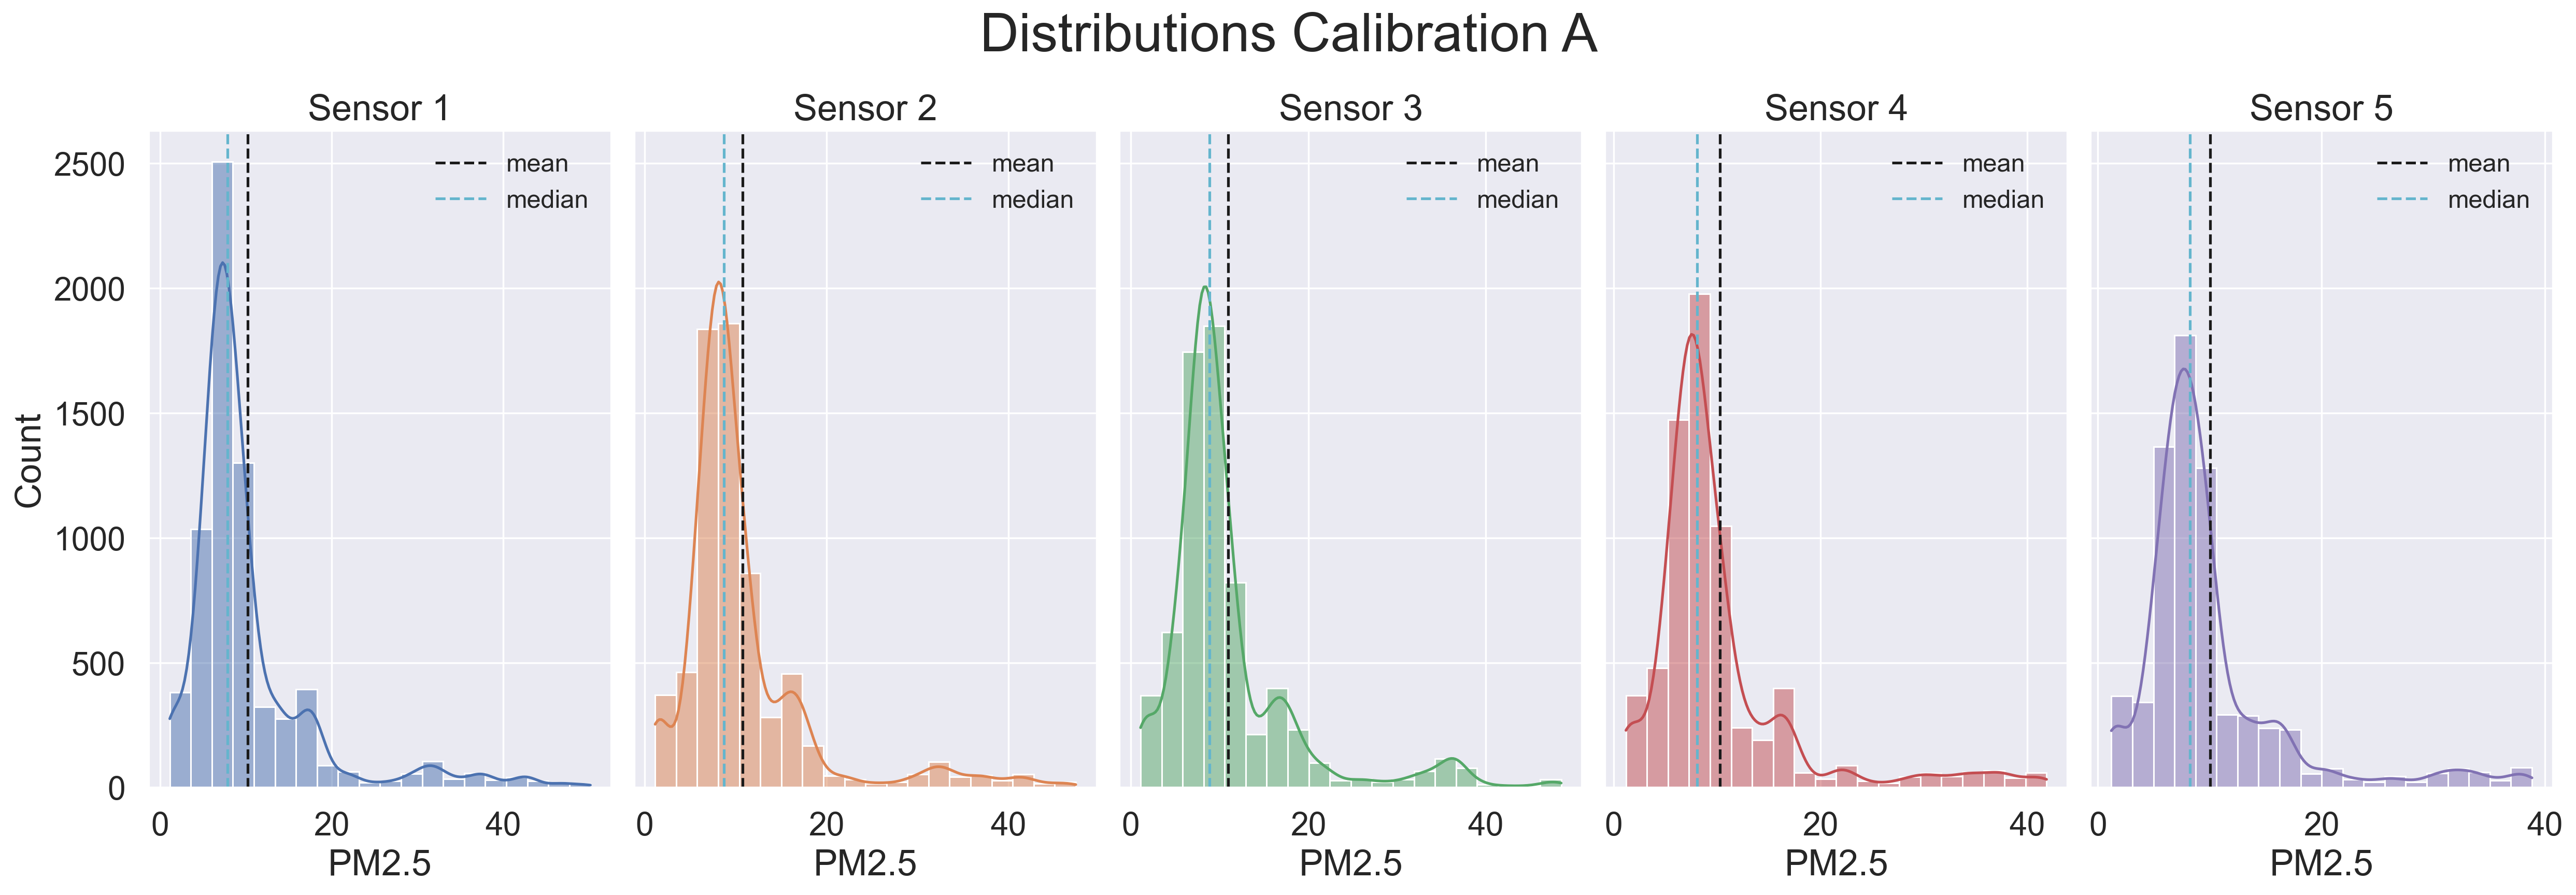

In [29]:
plot_sensor_distributions(
    c_df, 
    title='Distributions Calibration A', 
    fig_name=f'{fig_folder}/distributions({param}).pdf', 
    bins=20, 
    param=param
)

**Comment**

This gives us a nice general overview of the individual sensor distributions. They seem to roughly follow normal distributions, but to what extent? To get more exact values, let's use QQ-plots, skew, and kurtosis.

### 3.4 Normal distribution

In [30]:
normal = c_df.groupby('Sensor').agg({param: [skew, kurtosis]})

normal.head(10)

PM2.5          
            skew  kurtosis
Sensor                    
1       2.497794  6.919056
2       2.444282  6.819701
3       2.315911  6.126895
4       2.360467  5.967408
5       2.234691  5.462920

Compare with values

**Comment**

Sensor 1 has the highest absolute skew and kurtosis. Sensor 6 has the lowest skew while Sensor 3 has the least amount of kurtosis. This is interesting as Sensor 3 had the most outliers in numbers.

#### QQ Plots

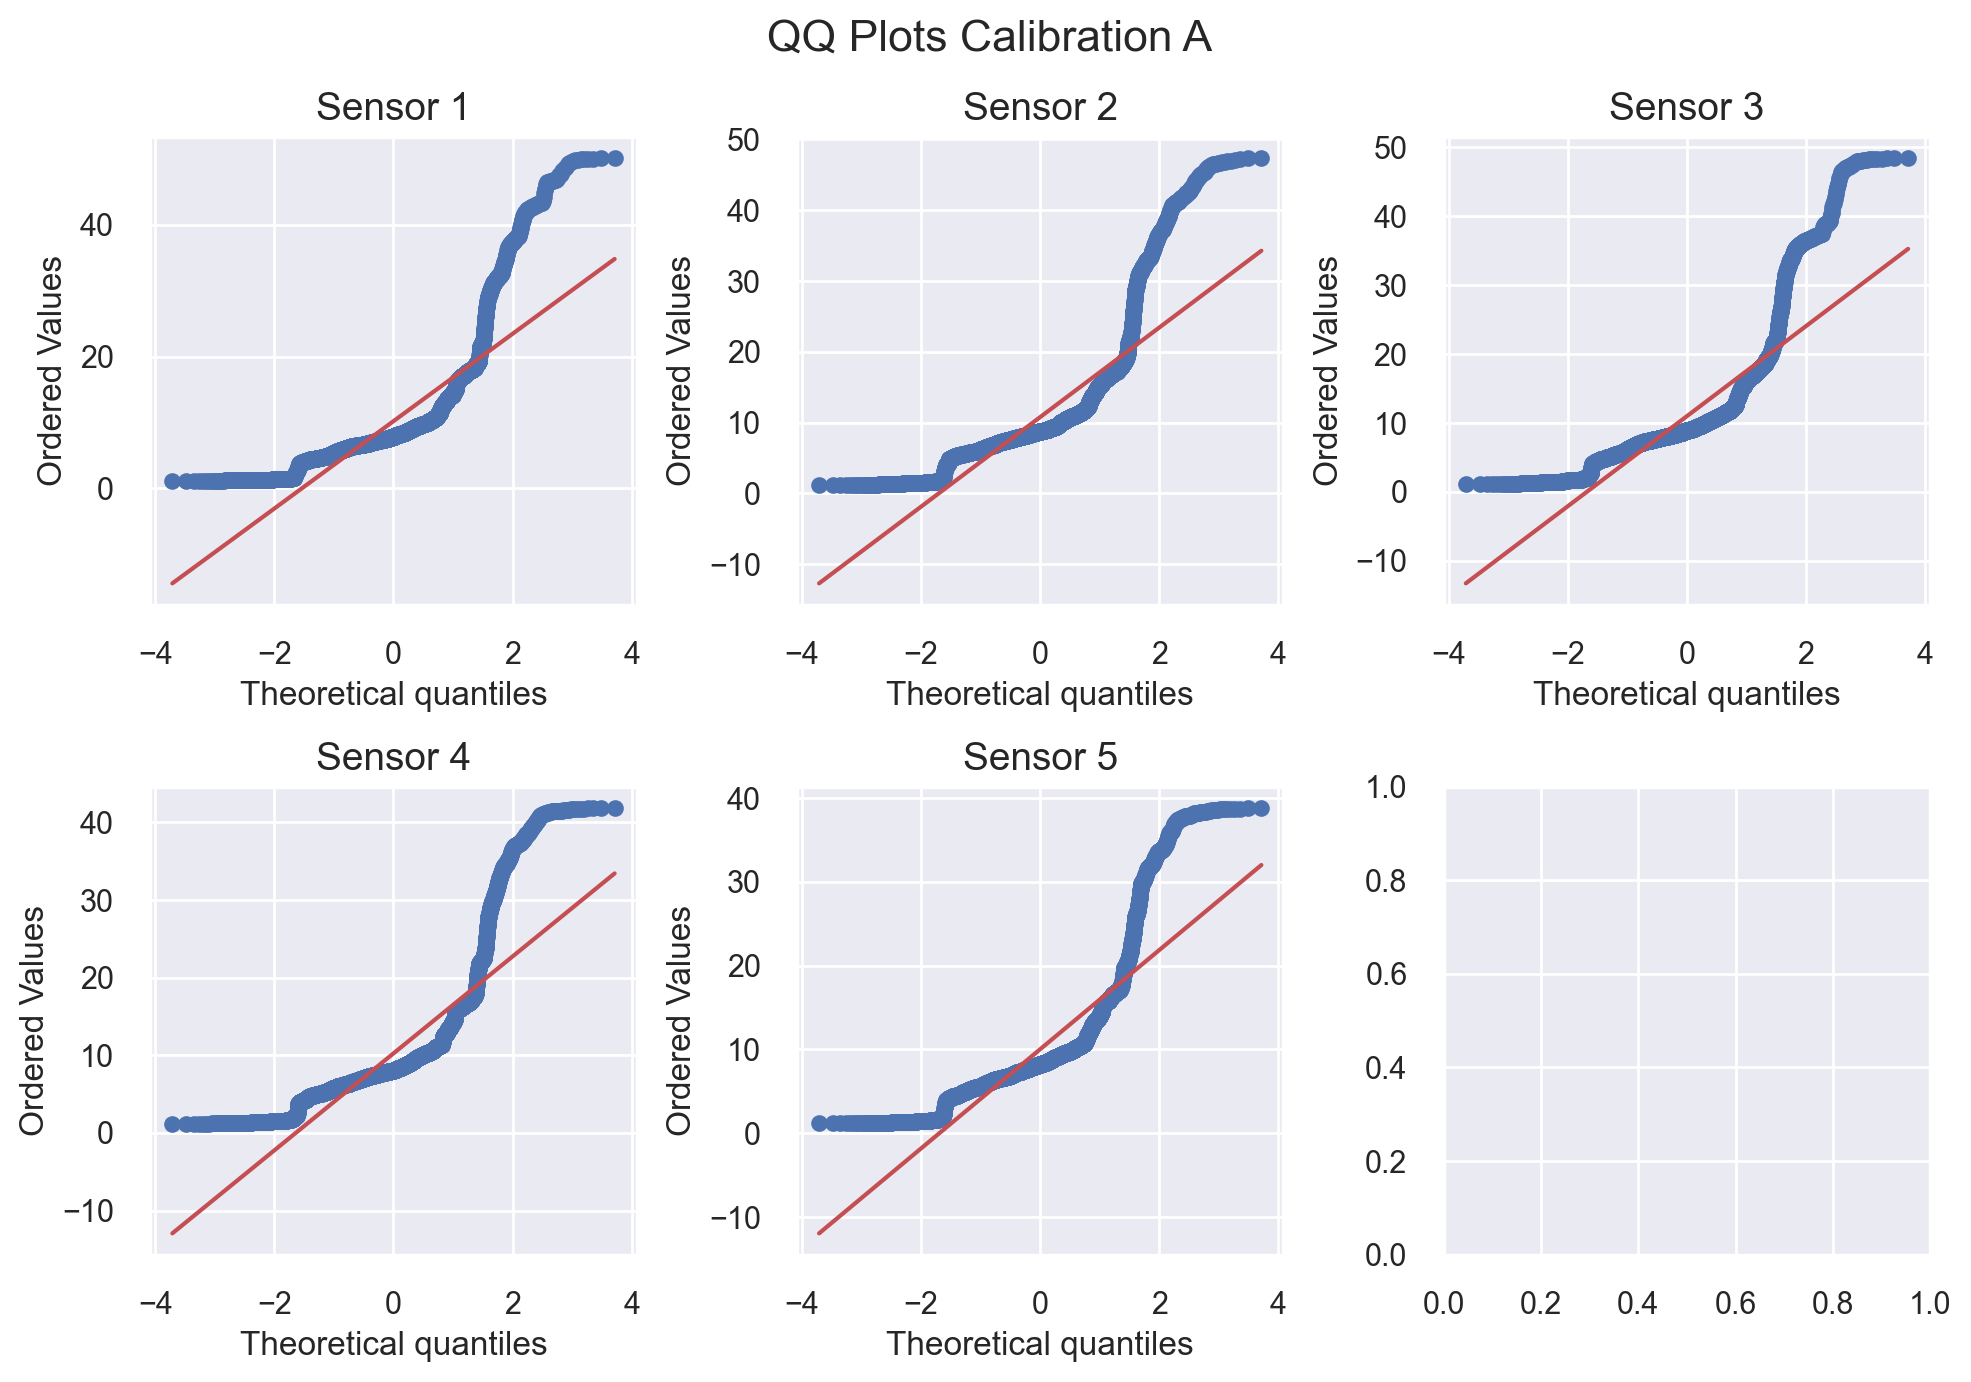

In [31]:
plot_QQ_plots(
    c_df, 
    title='QQ Plots Calibration A', 
    param=param, 
    fig_name=f'{fig_folder}/QQPlots({param}).pdf'
)

**Comment**

Based on visuals from the above graphs, all sensors seem to follow a normal distribution quite well.

## 4 Comparison among sensors and between them

### 4.1 Distribution

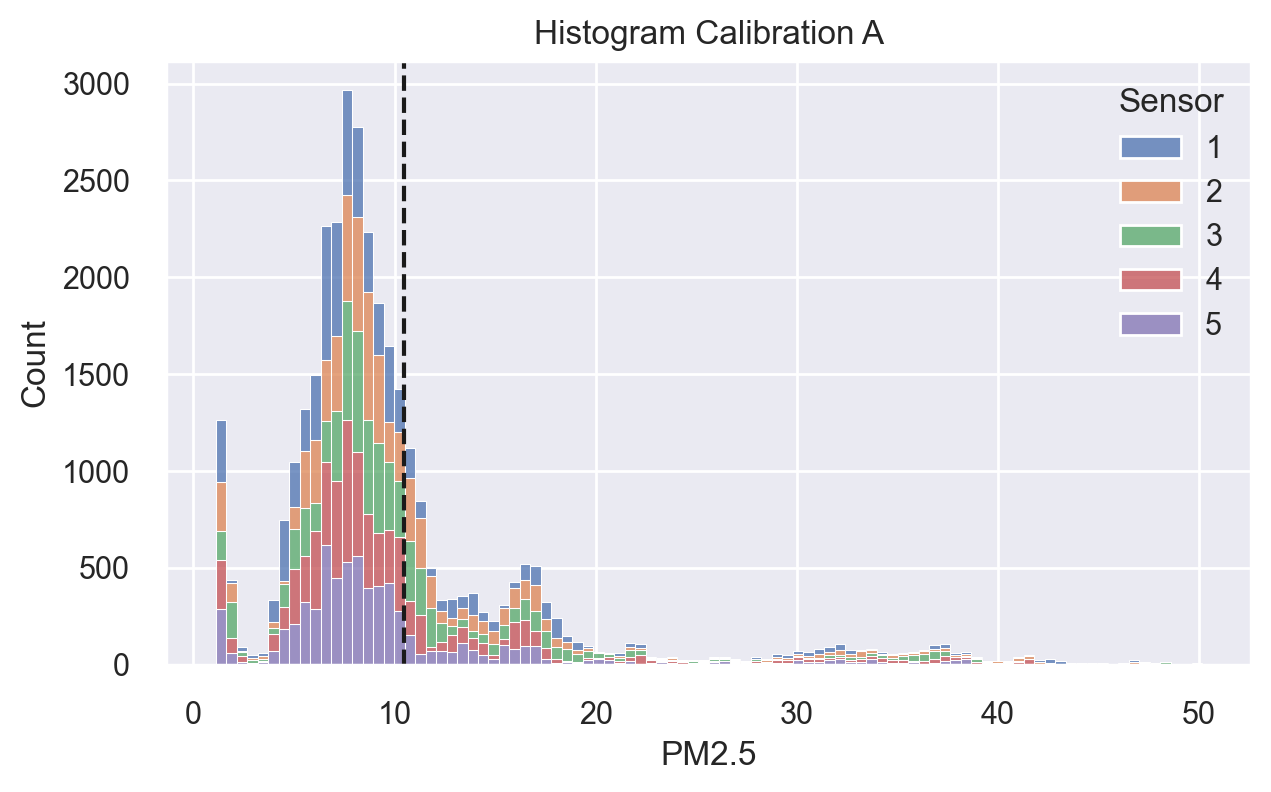

In [32]:
fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(c_df, x=param, hue='Sensor', multiple='stack', bins=94)
plt.axvline(grand_mean, c='k', linestyle='--', label='mean', linewidth=1.5)
plt.title('Histogram Calibration A')

plt.savefig(f'{fig_folder}/histogram({param}).pdf')

plt.show()

In [33]:
grand_skew = stats.skew(c_df[param], bias=False)
grand_kurtosis = stats.kurtosis(c_df[param], bias=False)

print(f'Skew: {grand_skew}')
print(f'Kurtosis: {grand_kurtosis}')
print(f'Std: {grand_std}')

Skew: 2.3833759265288554
Kurtosis: 6.396625582933822
Std: 7.399706484290808


**Comment**

Slightly longer tail on the right side (positive skew) than a normal distribution. Low kurtosis.

## 5 Other 

### 5.1 Pairplots

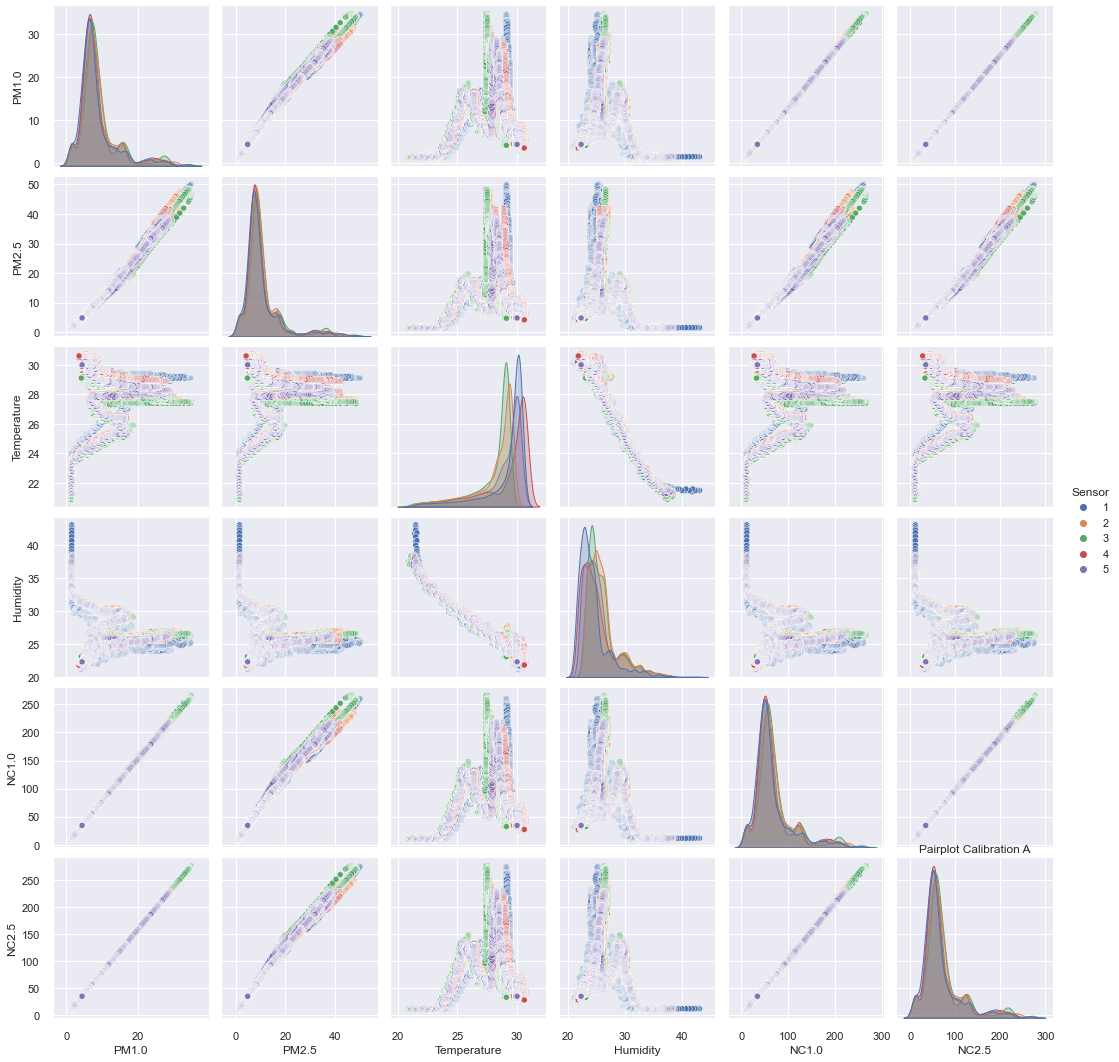

In [34]:
pair_df = c_df.copy()

pair_df = pair_df[['PM1.0', 'PM2.5', 'Temperature', 'Humidity', 'NC1.0', 'NC2.5', 'Sensor']]

sns.pairplot(pair_df, hue='Sensor')

plt.savefig(f'{fig_folder}/pariplot.pdf')

plt.title('Pairplot Calibration C')
plt.show()

## ANOVA

In [35]:
anova_df = perform_ANOVA(
    c_df,
    param=param,
    alpha=0.1,
)

anova_df

,0
SST,1860049.636143
SSW,1855379.944158
SSB,4669.691984
Alpha,0.1
F-stat,21.371736
F-crit,1.945026
P-value,0.0
F-stat > F-crit,True (Significant Difference)
p-value < alpha,True (Significant Difference)


In [36]:
sensor_data = []

for sensor in c_df['Sensor'].unique():
    sensor_data.append(c_df.loc[c_df['Sensor'] == sensor][param].values)
    
f_oneway(*sensor_data)

F_onewayResult(statistic=21.371735536093254, pvalue=1.2586766151280039e-17)

### Tukey-test

In [37]:
tukey_df = c_df[[param, 'Sensor']]

tukey = pairwise_tukeyhsd(
    endog=tukey_df[param],
    groups=tukey_df['Sensor'],
    alpha=0.1
)

print(tukey)

Multiple Comparison of Means - Tukey HSD, FWER=0.10 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
     1      2    0.568  0.001  0.2562  0.8798   True
     1      3   0.7915  0.001  0.4798  1.1031   True
     1      4   0.0369    0.9 -0.2748  0.3487  False
     1      5  -0.1806 0.5969 -0.4923  0.1312  False
     2      3   0.2235 0.3975 -0.0885  0.5354  False
     2      4  -0.5311  0.001 -0.8431  -0.219   True
     2      5  -0.7485  0.001 -1.0606 -0.4365   True
     3      4  -0.7545  0.001 -1.0664 -0.4426   True
     3      5   -0.972  0.001 -1.2839 -0.6601   True
     4      5  -0.2175 0.4266 -0.5295  0.0945  False
----------------------------------------------------


# Sensor variations from mean

In [38]:
# Compute sensor "Mean" as the mean of all sensor for every timestamp

mean_df = c_df.groupby('Timestamp').mean()
mean_df['Timestamp'] = mean_df.index
mean_df['Sensor'] = 'Mean'
mean_df['UID'] = 'Mean'

mean_df.reset_index(drop=True, inplace=True)

total_df = pd.concat([c_df, mean_df])

In [39]:
total_df

,Counter,Latitude,Longitude,gpsUpdated,Speed,Altitude,Satellites,Date,Time,Millis,...,NC10,TypicalParticleSize,TVOC,eCO2,BatteryVIN,compensatedT,compensatedRH,UID,Sensor,Timestamp
0,150.0,0.000000,0.000000,0.0,-1.000000,0.000000,0.000000,20220116.0,172021.0,1.777670e+05,...,10.700000,0.490000,0.0,0.0,3.51,17.400000,52.800000,B1F,1,2021-12-14 19:20:21
1,151.0,0.000000,0.000000,0.0,-1.000000,0.000000,0.000000,20220116.0,172021.0,1.788440e+05,...,10.890000,0.490000,0.0,0.0,3.51,17.500000,51.600000,B1F,1,2021-12-14 19:20:21
2,152.0,0.000000,0.000000,0.0,-1.000000,0.000000,0.000000,20220116.0,172023.0,1.799210e+05,...,10.990000,0.490000,0.0,0.0,3.51,17.500000,51.200000,B1F,1,2021-12-14 19:20:23
3,153.0,0.000000,0.000000,0.0,-1.000000,0.000000,0.000000,20220116.0,172024.0,1.809940e+05,...,11.180000,0.490000,0.0,0.0,3.51,17.500000,51.300000,B1F,1,2021-12-14 19:20:24
4,154.0,0.000000,0.000000,0.0,-1.000000,0.000000,0.000000,20220116.0,172025.0,1.820610e+05,...,11.310000,0.490000,0.0,0.0,3.51,17.500000,52.500000,B1F,1,2021-12-14 19:20:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7288,6944.0,59.344669,17.894092,1.0,1.433333,9.333333,5.666667,20220116.0,192150.0,7.462377e+06,...,31.303333,0.693333,0.0,0.0,3.49,26.266667,27.333333,Mean,Mean,2021-12-14 21:21:50
7289,6957.0,59.344832,17.894035,1.0,0.000000,28.700000,8.000000,20220116.0,192151.0,7.467967e+06,...,30.980000,0.760000,0.0,0.0,3.67,26.200000,27.000000,Mean,Mean,2021-12-14 21:21:51
7290,6958.0,59.344832,17.894029,1.0,0.000000,28.800000,8.000000,20220116.0,192152.0,7.469036e+06,...,31.080000,0.760000,0.0,0.0,3.67,26.200000,27.000000,Mean,Mean,2021-12-14 21:21:52
7291,6959.0,59.344832,17.894025,1.0,0.000000,29.000000,8.000000,20220116.0,192153.0,7.470104e+06,...,31.130000,0.760000,0.0,0.0,3.67,26.200000,27.000000,Mean,Mean,2021-12-14 21:21:53


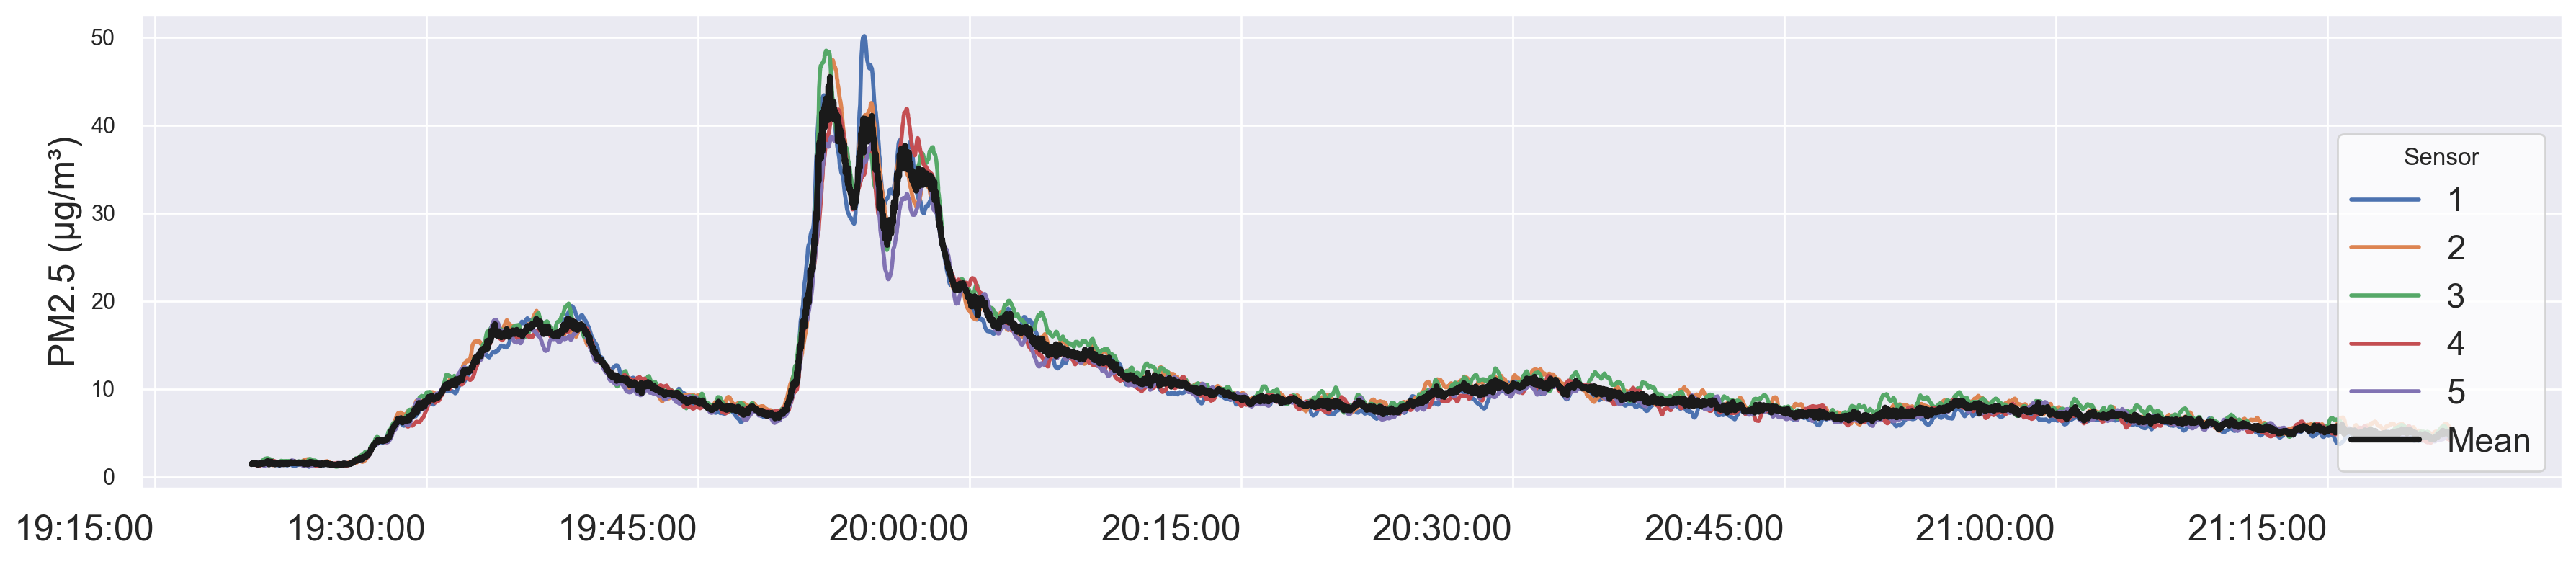

In [40]:
plot_sensors_over_time(
    total_df, 
    title='Calibration A Sensirion With Mean', 
    param=param, 
    size=[18,4],
    fig_name=f'{fig_folder}/sensirion_over_time_mean({param}).pdf',
    unit=unit
)

In [58]:
# How much do the sensors differ from the mean line?

diffs = {}

for timestamp, grp in c_df.groupby('Timestamp'):
    stamp_mean = grp[param].mean()
    
    for sensor, sensor_grp in grp.groupby('Sensor'):
        if sensor not in diffs:
            diffs[sensor] = []
        
        diffs[sensor].append(sensor_grp.iloc[0][param] - stamp_mean)

[]

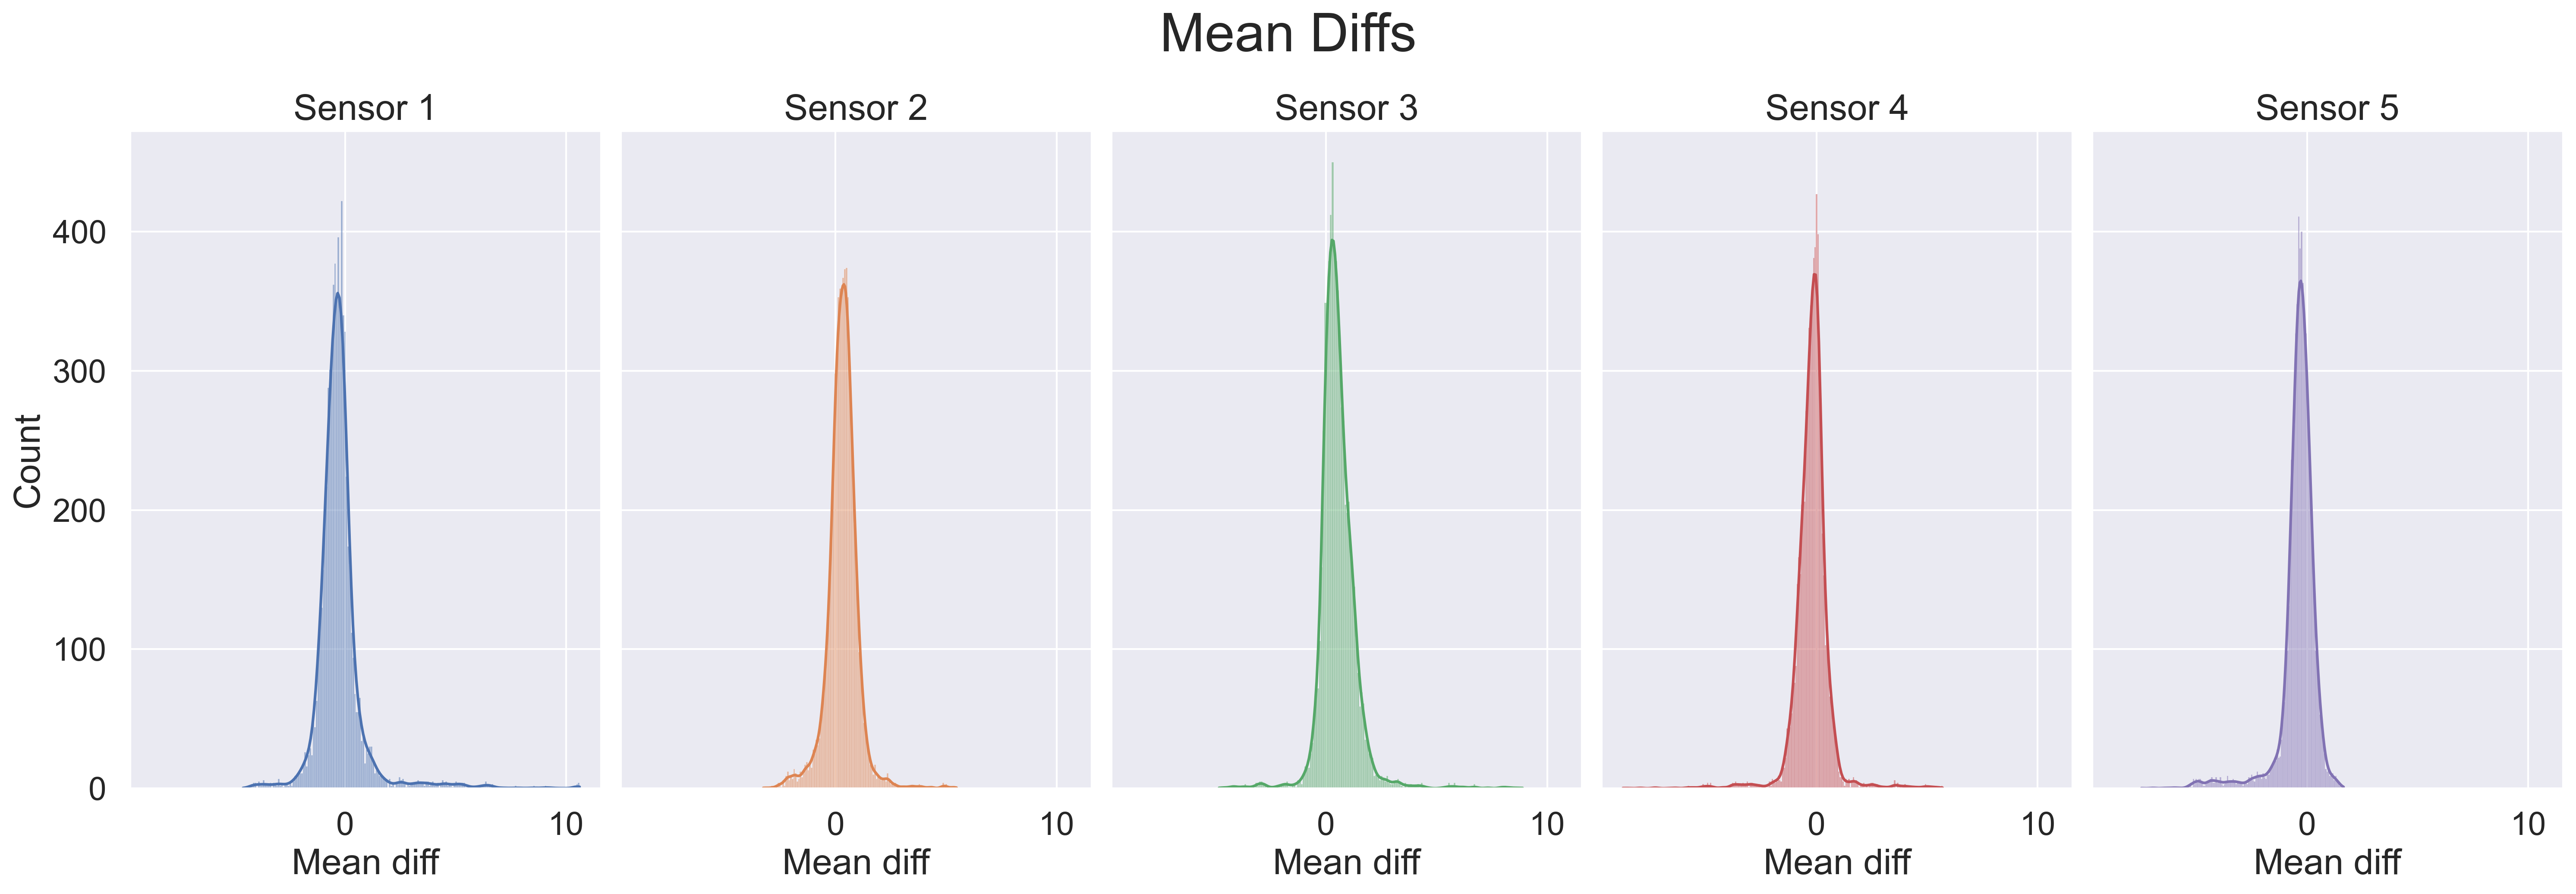

In [52]:
fig, axs = plt.subplots(ncols=len(c_df['Sensor'].unique()), dpi=300, sharey=True, sharex=True, figsize=[20, 7])

i = 0
for sensor in c_df['Sensor'].unique():
   
    sns.histplot(diffs[sensor], ax=axs[i], kde=True, color=sns.color_palette()[i])
 
    axs[i].tick_params(axis="x", labelsize=18)
    axs[i].tick_params(axis="y", labelsize=18)

    axs[i].set_xlabel('Mean diff', fontsize=20)
    axs[i].set_ylabel("Count", fontsize=20)
    axs[i].set_title(f"Sensor {sensor}", fontsize=20)

    i += 1

plt.tight_layout()
fig.subplots_adjust(top=0.85)
fig.suptitle('Mean Diffs', fontsize=30)

fig_name=f'{fig_folder}/sensirion_diffs({param}).pdf'

if fig_name:
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")

plt.plot()

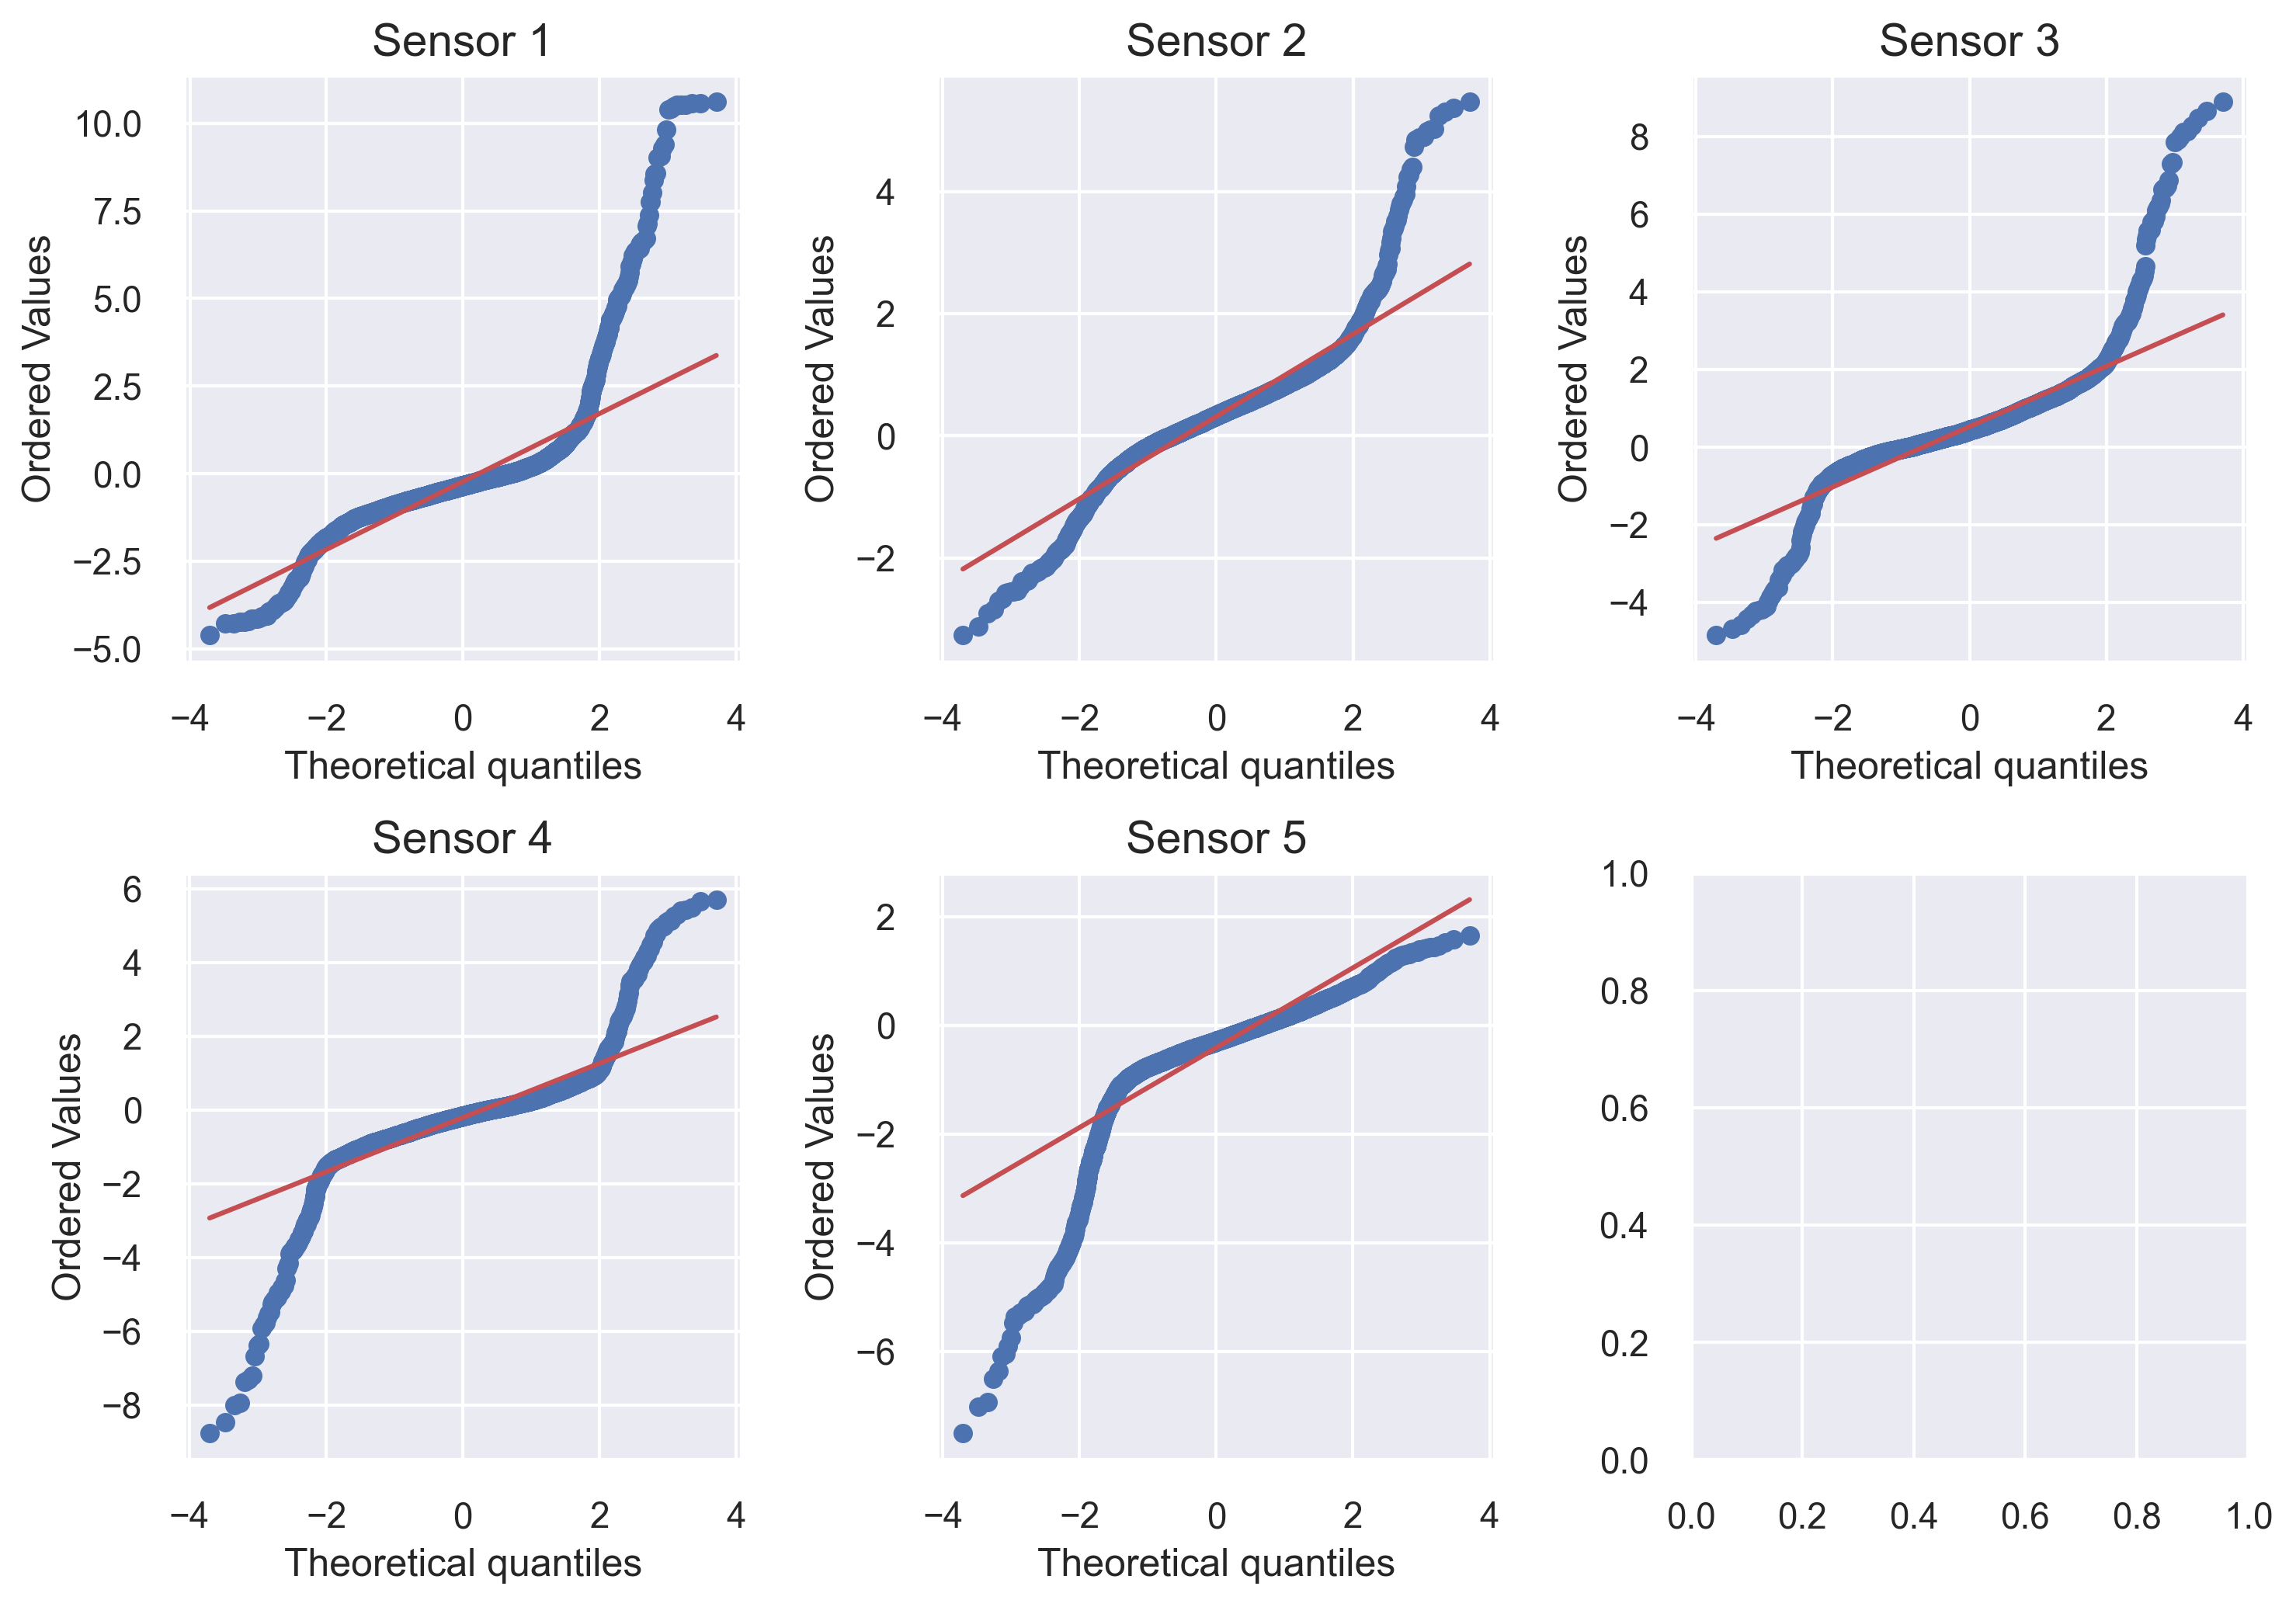

In [53]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=[10, 7], dpi=300)

for sensor, ax in zip(c_df['Sensor'].unique(), axs.flatten()):
    stats.probplot(diffs[sensor], dist="norm", plot=ax)
    ax.set_title(f"Sensor {sensor}", fontsize=14)

#plt.suptitle('QQ Plots Diffs', fontsize=16)
plt.tight_layout()

fig_name=f'{fig_folder}/sensirion_diffs_qqplots({param}).pdf'
if fig_name:
    plt.savefig(fig_name, dpi=300, bbox_inches="tight")

plt.show()

In [54]:
# Diffs in one plot

In [55]:
diffs.keys()

dict_keys(['1', '3', '4', '5', '2'])

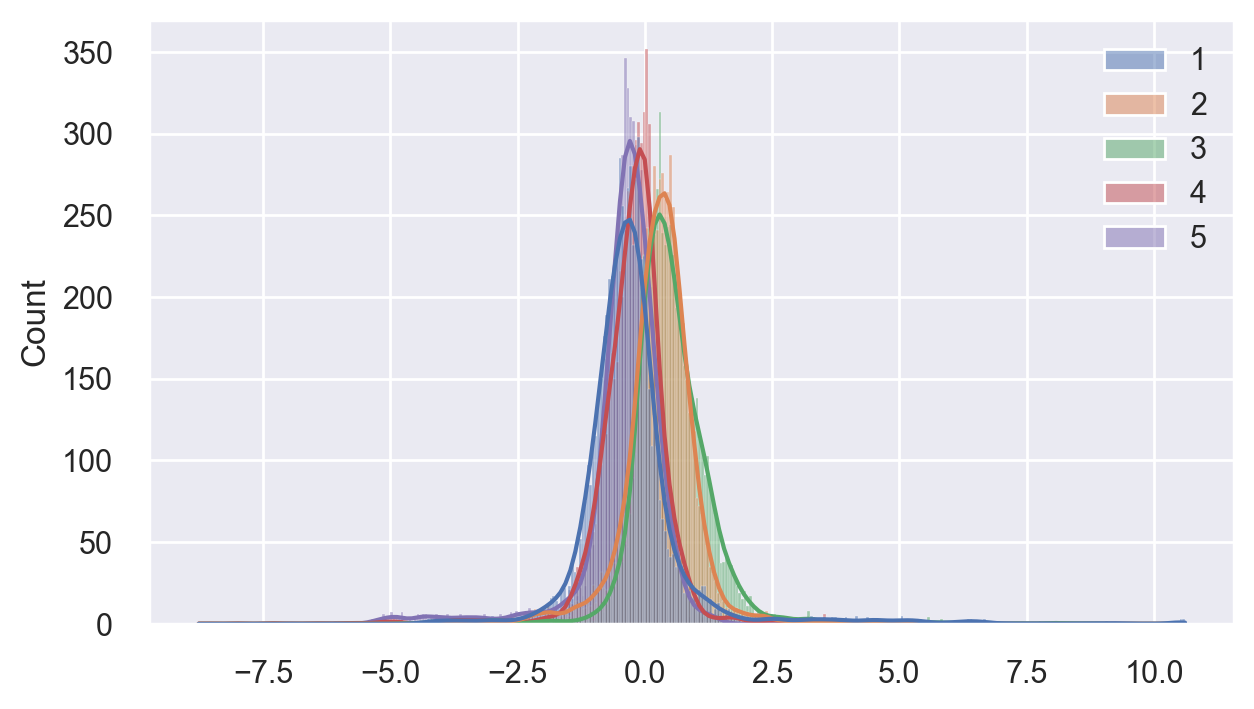

In [101]:
import collections

diffs = collections.OrderedDict(sorted(diffs.items()))

fig, ax = plt.subplots(figsize=[7,4], dpi=200)

sns.histplot(diffs, kde=True, ax=ax)
#plt.axvline(0, linestyle='--', c='#999')
#sns.kdeplot(data=diffs)

#plt.savefig(f'{fig_folder}/diff_distributions_kde({param}).pdf', dpi=300, bbox_inches="tight")

plt.show()

In [104]:
# ABOVE 30
range_df = c_df[(c_df[param] > 20)]

range_diffs = {}

for timestamp, grp in range_df.groupby('Timestamp'):
    stamp_mean = grp[param].mean()
    
    for sensor, sensor_grp in grp.groupby('Sensor'):
        if sensor not in range_diffs:
            range_diffs[sensor] = []
        
        range_diffs[sensor].append(sensor_grp.iloc[0][param] - stamp_mean)
        
range_diffs = collections.OrderedDict(sorted(range_diffs.items()))

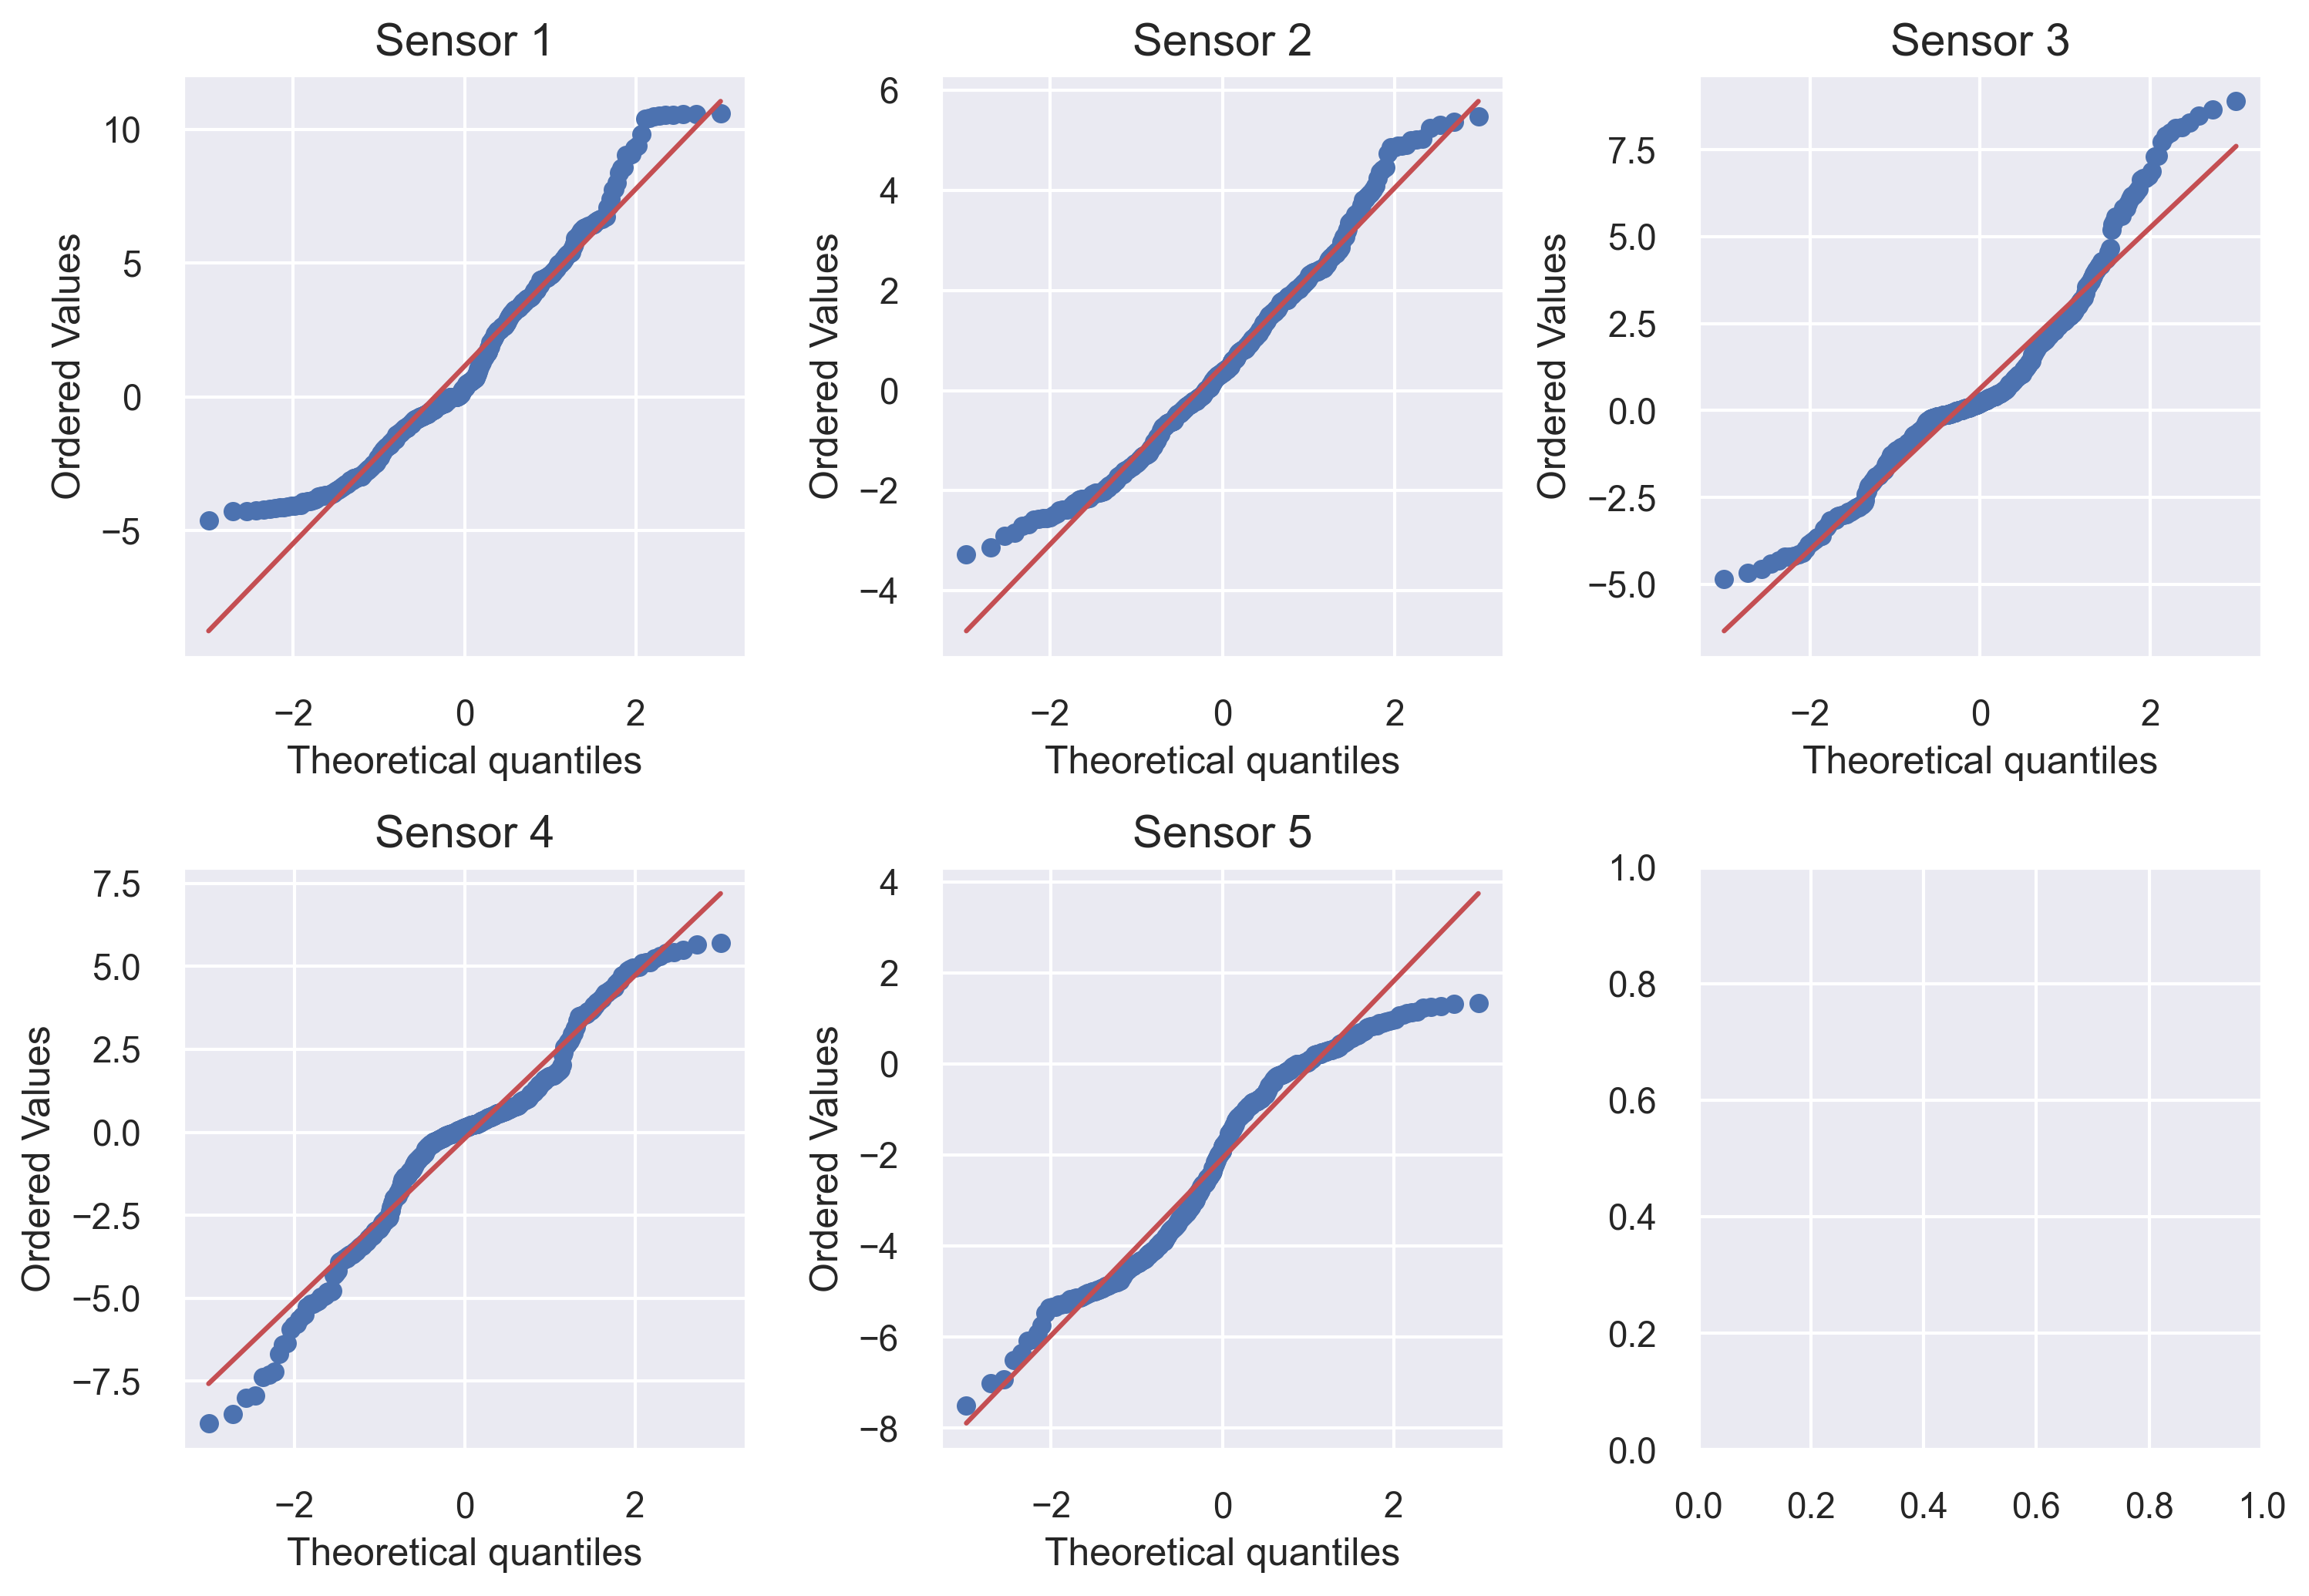

In [105]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=[10, 7], dpi=300)

for sensor, ax in zip(range_df['Sensor'].unique(), axs.flatten()):
    stats.probplot(range_diffs[sensor], dist="norm", plot=ax)
    ax.set_title(f"Sensor {sensor}", fontsize=14)

plt.tight_layout()

fig_name=f'{fig_folder}/sensirion_diffs_qqplots_20({param}).pdf'
#plt.savefig(fig_name, dpi=300, bbox_inches="tight")

plt.show()

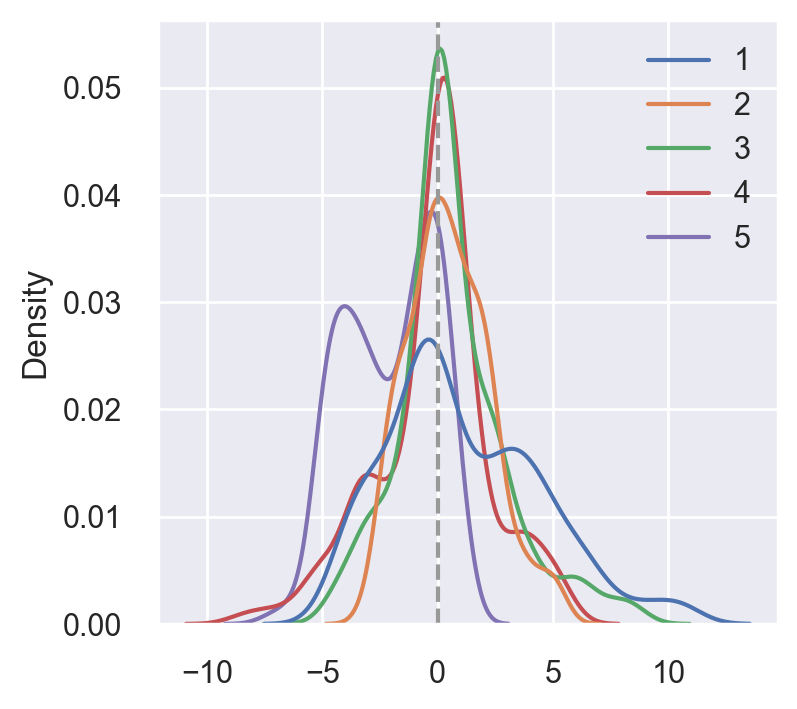

In [106]:
fig, ax = plt.subplots(figsize=[4,4], dpi=200)

#sns.histplot(range_diffs, kde=True, hist=False, ax=ax, bins=40)
sns.kdeplot(data=range_diffs, shade=False)
plt.axvline(0, linestyle='--', c='#999')

plt.savefig(f'{fig_folder}/diff_distributions_above20({param}).pdf', dpi=300, bbox_inches="tight")

plt.show()

In [107]:
range_df['Timestamp'].min()

Timestamp('2021-12-14 19:50:50')

In [108]:
range_df['Timestamp'].max()

Timestamp('2021-12-14 20:02:13')